# Julia Threads Introduction

## Threads

Threads are sequences of computation that can run independently on a CPU core,
simultaneously with other such sequences. 

How many threads should we have? The general advice is that the number of threads should correspond directly to the number of CPU cores of the computer used.


## CPU cores

How many CPU cores does your computer have? The answer might not be so easy to get to. One particular complication is hyper-threading. This is a facility that some Intel CPUs allow a single core to run multiple (usually 2) threads concurrently. However, this parallelism only allows one CPU instruction actually executed at one time. For CPU intensive programs, hyper-threading usually does not provide much benefit. So what we really want to count are physical CPU cores.

## Using `Hwloc.jl` 

https://github.com/JuliaParallel/Hwloc.jl

Hwloc.jl is a high-level wrapper of the hwloc library. 

The Portable Hardware Locality (hwloc) software package provides a portable abstraction (across OS, versions, architectures, ...) of the hierarchical topology of modern architectures, including NUMA memory nodes, sockets, shared caches, cores and simultaneous multithreading. It also gathers various system attributes such as cache and memory information as well as the locality of I/O devices such as network interfaces, InfiniBand HCAs or GPUs.

hwloc primarily aims at helping applications with gathering information about increasingly complex parallel computing platforms so as to exploit them accordingly and efficiently.

In [ ]:
using Hwloc

In [ ]:
num_physical_cores()

In [ ]:
num_virtual_cores()

In [ ]:
getinfo()

In [ ]:
cachesize()

In [ ]:
cachelinesize()

In [ ]:
topology()

In [ ]:
topology_graphical()

## Create a Julia Kernel to use multiple threads

Run Julia 1.9.0 Repl:

`julia> using IJulia`

`julia> IJulia.installkernel("Julia 12 Threads", env=Dict(
    "JULIA_NUM_THREADS" => "12",))`
    
Powershell on Windows:

`$env:JULIA_NUM_THREADS=4`
    
### Starting threads

In [ ]:
using Base.Threads

In [ ]:
# get the number of threads
nthreads()

In [ ]:
nthreadpools()

In [ ]:
# The threadid function returns the current thread ID;
threadid()

By default, all Julia code is running on the first thread.

In [ ]:
a = zeros(Int64, nthreads());
for i in 1:nthreads()
    a[i] = threadid()
end
a

## The `@threads` macro

In the for loop in the previous section, what we want is for each iteration of the loop to be executed on a different thread. In Julia, that is very easy to do. Julia supports parallel loops using the `Threads.@threads` macro. This macro is affixed in front of a for loop to indicate to Julia that the loop is a multi-threaded region whose use is illustrated in the following code:

In [ ]:
a = zeros(Int64, nthreads());
@threads for i in 1:nthreads()
    a[i] = threadid()
end
a

This example code shows how simple Julia's threading model is, at least in how it is presented to the developer—the idea being that annotated loops are automatically split among available threads, without the programmer having to explicitly break up computations, or assign the code to threads. This Julia approach to multi-threading is kind of like that in `OpenMP`.

In [ ]:
a = zeros(Int64, nthreads());
@threads for i in 1:nthreads()
    a[threadid()] += 1 
    println("loop ", i, " done by thread ", threadid())
end

In [ ]:
a = zeros(Int64, nthreads())
@threads for i in 1:2*nthreads()
    a[threadid()] += 1 
    #println("loop ", i, " done by thread ", threadid())
end

In [ ]:
for i in 1:nthreads()
    println(a[i])
end

# Static Scheduling

https://jaantollander.com/post/multithreading-in-julia-language-applied-to-cell-lists-algorithm/

If we can easily compute the exact workload of subtasks before execution, we can use static scheduling, which divides the workloads evenly for each available thread. Formally, dividing the subtasks is an optimization problem where we aim to **balance workload**. We may have to use heuristics if solving the exact value of the optimization problem is too difficult.

In Julia language, we can use the @threads macro for static scheduling of for-loops. It splits the iterations evenly among available threads. For example, we can sum an array of random numbers in parallel using static schedculing.

Note how we use nthreads and threadid to ensure that each threads writes data to thread-specific memory location to avoid data race.

In [ ]:
"""
   Multi-threaded sum

"""
a = rand(100000)  # Create array of random numbers
p = zeros(nthreads())  # Allocate a partial sum for each thread
# Threads macro splits the iterations of array `a` evenly among threads
@threads for x in a
   p[threadid()] += x  # Compute partial sums for each thread
end
s = sum(p)  # Compute the total sum

In [ ]:
"""
   Check workloads of each thread

"""
vec = fill(1,30)  # Create array of 30 ones
pv = zeros(Int64, nthreads())  
# Threads macro splits the iterations of array `a` evenly among threads
@threads for x in vec
   pv[threadid()] += x  # Compute partial sums for each thread
end
s = sum(pv)  # Compute the total sum

In [ ]:
for i in 1:nthreads()
    println(pv[i])
end

# Load Balancing

Consider the following muli-threaded code:

`@threads for i in 1:N`

             for j in i:N
                 a[i,j] = ...
             end 
          end`
   
In this code example, different i-loop has different workload. How can we have a thread workload schedule to make all threads have almost equal workload?

# Embarrassingly Parallel

https://en.wikipedia.org/wiki/Embarrassingly_parallel

In parallel computing, an embarrassingly parallel workload or problem (also called embarrassingly parallelizable, perfectly parallel, delightfully parallel or pleasingly parallel) is one where little or no effort is needed to separate the problem into a number of parallel tasks. This is often the case where there is little or no dependency or need for communication between those parallel tasks, or for results between them.

Examples of embarrassingly parallel problems:

- `for loops` with no dependency or need for writing to a same variable.


- `3D rendering` handled by a graphics processing unit, where each frame or pixel can be handled with no interdependency.


- Some forms of `password cracking` are another embarrassingly parallel task that is easily distributed on central processing units, CPU cores, or clusters

## Simple for loop parallelization

- `OpenMP` C example

`#pragma omp parallel for`

`for (i=0; i < N; i++)  a[i] = b[i]*b[i] + c[i]*c[i]`
 

- Julia `@threads` example

`@threads for i in 1:N`

`a[i] = b[i]*b[i] + c[i]*c[i]`

`end`


_Questions_: What work scheduling methods are used in OpenMP and Julia threads, respectively?


# Matrix Multiplication

### Using for-loops to implement Matrix Multiplication

#### sequential code

In [ ]:
function MM!(c, a, b, N)
    for i in 1:N
        for j in 1:N
            ctemp = zero(eltype(c))
            for k in 1:N
             @inbounds ctemp += a[i,k]*b[k,j] # Using @inbounds with care
            end
            c[i,j] = ctemp
        end
    end
end

#### muti-threaded code

In [ ]:
function MM_threads!(c, a, b, N)
    @threads for i in 1:N
        for j in 1:N
            ctemp = zero(eltype(c))
            for k in 1:N
             @inbounds ctemp += a[i,k]*b[k,j] # Using @inbounds with care
            end
            c[i,j] = ctemp
        end
    end
end

### Timing test:

In [ ]:
N = 2000

In [ ]:
a = rand(N,N);
b = rand(N,N);
c1 = Matrix{Float64}(undef, N, N);
c2 =  Matrix{Float64}(undef, N, N);

In [ ]:
@time MM!(c1, a, b, N)

In [ ]:
c1[1], c1[N*N]

In [ ]:
@time MM_threads!(c2, a, b, N)

In [ ]:
c2[1], c2[N*N]

In [ ]:
c1 == c2

### Using `LinearAlgebra` matrix multiplication operator (`*`)

In [ ]:
using LinearAlgebra

In [ ]:
BLAS.set_num_threads(6)

In [ ]:
BLAS.get_num_threads()

In [ ]:
@time c1 = a * b;

In [ ]:
c1[1,1], c1[N, N]

In [ ]:
c1 == c2

In [ ]:
@time mul!(c2, a, b);

In [ ]:
c2[1,1], c2[N, N]

In [ ]:
c1 == c2

# Compute and Display  Mandelbrot Set (Fractal)

https://en.wikipedia.org/wiki/Mandelbrot_set

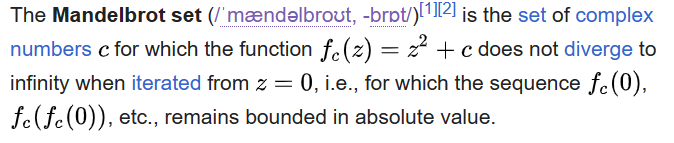


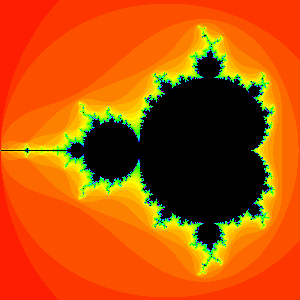
The black region is the Mandelbrot set. 
- It is symmetric with respect to the x-axis in the plane, 
- and its intersection with the x-axis occupies the interval from -2 to 1/4. 
- The point 0 lies within the main cardioid, and the point -1 lies within the bulb attached to the left of the main cardioid.

## Compute Mandelbrot set

In [ ]:
function setMandelbrotPixel(c, niter=255)
    1 ≤ niter ≤ 255 ? niter : 255
    z = zero(typeof(c))
    z = z*z + c
    for i in 1:niter
        abs2(z)> 4.0 && return (i-1)%UInt8
        z = z*z + c
    end
    return niter%UInt8
end

In [ ]:
setMandelbrotPixel(0.0+0.5im)

In [ ]:
setMandelbrotPixel(-2.0+0.1im)

In [ ]:
vc = [0.0 + x*im for x in -2:0.1:0]

In [ ]:
setMandelbrotPixel.(vc)

In [ ]:
function MandelbrotSet(niter=100, width=800, height=600,
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)

    pic = Matrix{UInt8}(undef, height, width)
      
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);
    
    # Compute pic column by column
    for j in 1:width
        x = x_start+(j-1)*dx
        for i in 1:height
            # (i,j) ==> (x,y) 2D linear transformation      
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel(x+y*im, niter)
        end
    end
    
    return pic
end

In [ ]:
mandel = MandelbrotSet();

In [ ]:
typeof(mandel), size(mandel)

## Display Mandelbrot Set

In [ ]:
using Plots

#### Plots heatmap demo

In [ ]:
data = rand(8,10)
heatmap(1:size(data,2), # x value axis
    1:size(data,1),     # y value axis
    data,
    c=cgrad([:blue, :white,:red, :yellow]),
    xlabel="x values", ylabel="y values",
    title="My heatmap demo")

In [ ]:
using ColorSchemes

In [ ]:
ColorSchemes.:ice.colors

In [ ]:
length(ColorSchemes.:ice.colors)

In [ ]:
length(ColorSchemes.:Spectral.colors)

In [ ]:
length(ColorSchemes.:leonardo.colors)

### Display Mandelbrot set using heatmap

In [ ]:
heatmap(1:size(mandel,2),1:size(mandel,1), mandel, color = :thermal)

In [ ]:
mandel_2 = MandelbrotSet(255, 200, 400);

In [ ]:
typeof(mandel_2), size(mandel_2)

In [ ]:
heatmap(1:size(mandel_2,2),1:size(mandel_2,1), mandel_2, color = :ice)

In [ ]:
mandel_3 = MandelbrotSet(100, 600, 800, 0.0, -0.3, 0.5, 0.3);

In [ ]:
typeof(mandel_3), size(mandel_3)

In [ ]:
heatmap(1:size(mandel_3,2),1:size(mandel_3,1), mandel_3, color = :thermal)

## Parallel Computing of Mandelbrot Set

In [ ]:
function MandelbrotSet_threads(niter=100, width=800, height=600,
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)

    pic = Matrix{UInt8}(undef, height, width)
      
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);
    
    # Compute pic column by column
    @threads for j in 1:width
        x = x_start+(j-1)*dx
        for i in 1:height
            # (i,j) ==> (x,y) 2D linear transformation      
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel(x+y*im, niter)
        end
    end
    
    return pic
end

### Timing comparison of squential vs. multi-threads

In [ ]:
@time mandel = MandelbrotSet();

In [ ]:
@time mandel_t = MandelbrotSet_threads();

In [ ]:
mandel == mandel_t

In [ ]:
@time mandel = MandelbrotSet(255, 1000, 1000);

In [ ]:
@time mandel_t = MandelbrotSet_threads(255, 1000, 1000);

# Compute and Display Julia Set

https://en.wikipedia.org/wiki/Julia_set

**Source** 
http://www.cs.unb.ca/~aubanel/JuliaMultithreadingNotes.html

Notes on Multithreading with Julia by Eric Aubanel June 2020


## Compute Julia set

In [ ]:
function juliaSetPixel(z0, c)
    z = z0
    niter = 255
    for i in 1:niter
        abs2(z)> 4.0 && return (i - 1)%UInt8
        z = z*z + c
    end
    return niter%UInt8
end

In [ ]:
function calcColumn!(pic, c, n, j)
    x = -2.0 + (j-1)*4.0/(n-1)
    for i in 1:n
        y = -2.0 + (i-1)*4.0/(n-1)
        @inbounds pic[i,j] = juliaSetPixel(x+im*y, c)
    end
    nothing
end

In [ ]:
function juliaSetCalc!(pic, c, n)
    for j in 1:n
        calcColumn!(pic, c, n, j)
    end
    nothing
end

In [ ]:
function juliaSet(x, y, n=1000, method = juliaSetCalc!, extra...)
    c = x + y*im
    pic = Matrix{UInt8}(undef,n,n)
    method(pic, c, n, extra...)
    return pic
end

In [ ]:
frac = juliaSet(-0.79,0.15);

## Display Julia Set using heatamp

In [ ]:
using Plots

In [ ]:
#heatmap(1:size(frac,1),1:size(frac,2), frac, color = :thermal)  # color is a ColorSchemes object
#heatmap(1:size(frac,1),1:size(frac,2), frac, color = :leonardo)
heatmap(1:size(frac,2),1:size(frac,1), frac, color = :ice)
#heatmap(1:size(frac,1),1:size(frac,2), frac, color = :rainbow)
# heatmap(1:size(frac,1),1:size(frac,2), frac, color=:Spectral))

In [ ]:
frac2 = juliaSet(−0.70176, −0.3842);
heatmap(1:size(frac2,2),1:size(frac2,1), frac2, color = :Spectral)

In [ ]:
frac3 = juliaSet(−0.4, 0.6); 
heatmap(1:size(frac3,2),1:size(frac3,1), frac3, color = :ice)

In [ ]:
heatmap(1:size(frac3,2),1:size(frac3,1), frac3, color = :Spectral)

## Parallel Computing of Julia Set

In [ ]:
function juliaSetCalcThread!(pic, c, n)
    @threads for j in 1:n
        calcColumn!(pic, c, n, j)
    end
    nothing
end

## Timing comparison of squential vs. multi-threads

In [ ]:
@time julia = juliaSet(-0.79,0.15);

In [ ]:
@time julia_t = juliaSet(-0.79,0.15,1000,juliaSetCalcThread!);

# Parallel (sum) Reduction

In [ ]:
"""
    Sequential reduction

"""
function sum_sequential(x)
    r = zero(eltype(x))
    for i in eachindex(x)
        @inbounds r += x[i]
    end
    return r
end

In [ ]:
"""
    Multi-threaded reduction

"""
function sum_threads(x)
    r = zero(eltype(x))
    @threads for i in eachindex(x)
        @inbounds r += x[i]
    end
    return r
end

## Compare sequential threaded reduction

In [ ]:
a=rand(10_000_000);

In [ ]:
@time sum_sequential(a)

In [ ]:
@time sum_threads(a)

### Result comparison

Not only is the `sum_threads` function producing the wrong
answer, but it is also much slower than `sum_sequential`. 

The problem with correctness may be apparent; inside
the loop, we are trying to read and write to r, the result variable. Doing that simultaneously
in multiple threads leads to wrong values, since one thread may be reading one value, and
then trying to increment that, while another thread writes a different value before the first
thread has finished (**race condition**).

One solution to this is to create r as an `atomic variable`. In this case, adding a value to r will
be a single indivisible operation. That is, the act of adding a value to r (and writing the
result back to r) will be an operation that cannot be interrupted by any other thread. The
atomic addition is performed by the `atomic_add!` method, which works with an atomic
variable. Using this facility in the following code fixes the error in the answer:

In [ ]:
function sum_threads_atomic(x)
    r = Atomic{eltype(x)}(zero(eltype(x)))
    @threads for i in eachindex(x)
        @inbounds atomic_add!(r, x[i])
    end
    return r[]
end

In [ ]:
@time sum_threads_atomic(a)

So, using an atomic add fixes our correctness issue. But the threaded addition is even much
slower than the sequential code. 
Consider following muti-threaded impelemetation:

In [ ]:
"""
    Multi-threaded reduction with partial sum

"""
function sum_threads_p(x)
    r = zero(eltype(x))
    p = zeros(eltype(x), nthreads())
    @threads for i in eachindex(x)
        @inbounds  p[threadid()] += x[i]
    end
    
    @simd for i in 1:nthreads()
        @inbounds r += p[i]
    end
    
    return r
end

In [ ]:
@time sum_threads_p(a)

### Summary 0f all timing results

In [ ]:
a=rand(10_000_000);

In [ ]:
@time sum_sequential(a)

In [ ]:
@time sum_threads(a)

In [ ]:
@time sum_threads_atomic(a)

In [ ]:
@time sum_threads_p(a)

In [ ]:
# Using Base sum function
@time sum(a)